In [15]:
import cv2
from tqdm import tqdm
import numpy as np
import os
import pandas as pd
from sklearn.metrics import fbeta_score
import glob
from sklearn.model_selection import train_test_split
import shutil

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.callbacks import LambdaCallback, EarlyStopping

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def parse_labels(df_train):
    labels = [
        'slash_burn',
        'clear',
        'blooming',
        'primary',
        'cloudy',
        'conventional_mine',
        'water',
        'haze',
        'cultivation',
        'partly_cloudy',
        'artisinal_mine',
        'habitation',
        'bare_ground',
        'blow_down',
        'agriculture',
        'road',
        'selective_logging'
    ]

    l_map = {l: i for i, l in enumerate(labels)}
    inv_map = {i: l for l, i in l_map.items()}
    return labels, l_map, inv_map

# Parse labels
inputs_dir = 'inputs'
print("Read inputs from: %s" % inputs_dir)
df_csv = pd.read_csv(os.path.join(inputs_dir, 'train_v2.csv'))
data_dir = os.path.join(inputs_dir, 'train-jpg')
labels, label_map, inv_label_map = parse_labels(df_csv)

Read inputs from: inputs


In [4]:
subset_size = None
img_size = 128
X = []
Y = []
# for f, tags in tqdm(df_train.sample(subset_size).values, miniters=1000):
if subset_size is not None:
    data_progress = tqdm(df_csv.sample(subset_size).values, miniters=1000)
else:
    data_progress = tqdm(df_csv.values, miniters=1000)

for f, tags in data_progress:
    f_name = '{}.jpg'.format(f)
    img = cv2.imread(os.path.join(data_dir, f_name))
    targets = np.zeros(17)
    for t in tags.split(' '):
        targets[label_map[t]] = 1
    if img_size is not None:
        X.append(cv2.resize(img, (img_size, img_size)))
    else:
        X.append(img)
    Y.append(targets)
print("Creating numpy array for data...")
X = np.array(X, np.float16) / 255.
Y = np.array(Y, np.uint8)

100%|██████████| 40479/40479 [00:43<00:00, 922.14it/s]


Creating numpy array for data...


In [5]:
data_split_seed = 0
X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, test_size=0.2, random_state=data_split_seed)

In [8]:
import random
def randomTranspose(img, u=0.5):
    if random.random() < u:
        img = img.transpose(1,0,2)  #cv2.transpose(img)
    return img

datagen = ImageDataGenerator(
    vertical_flip=True,
    horizontal_flip=True,
    preprocessing_function = randomTranspose,
    shear_range=0.5,
    zoom_range=0.2,
    height_shift_range=0.1,
    rotation_range=10,
    )

# datagen.fit(X, seed=0)

In [20]:
model = Sequential()
model.add(BatchNormalization(input_shape=(img_size,img_size,3)))
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.25))

model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(17, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [21]:
np.random.seed(0)
scores = []
batch_size = 128
epochs = 200

steps = int(len(X_train)/batch_size)

def my_callback_func(batch,logs):
    p_valid = model.predict(X_valid, batch_size=batch_size,verbose=2)
    score = fbeta_score(Y_valid, np.array(p_valid) > 0.2, beta=2, average='samples')
    print("Validation fscore: %.5f" % score)
    scores.append(score)


my_callback = LambdaCallback(on_epoch_end=lambda batch,logs: my_callback_func(batch,logs))
early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=0)
# callbacks = [my_callback, early_stop]
callbacks = [my_callback]

train_generator = datagen.flow(X_train, Y_train, batch_size=batch_size, seed=0)

history_callback = model.fit_generator(train_generator, steps_per_epoch=steps, epochs=epochs, verbose=2,
          validation_data=(X_valid, Y_valid), callbacks=callbacks)

print("Max score %f at epoch %d" % (np.max(scores), np.argmax(scores)))

Epoch 1/200
Validation fscore: 0.71214
107s - loss: 0.2758 - acc: 0.9036 - val_loss: 0.2515 - val_acc: 0.9052
Epoch 2/200
Validation fscore: 0.78474
86s - loss: 0.1738 - acc: 0.9325 - val_loss: 0.1892 - val_acc: 0.9266
Epoch 3/200
Validation fscore: 0.85767
88s - loss: 0.1607 - acc: 0.9375 - val_loss: 0.1497 - val_acc: 0.9422
Epoch 4/200
Validation fscore: 0.87080
85s - loss: 0.1550 - acc: 0.9402 - val_loss: 0.1523 - val_acc: 0.9442
Epoch 5/200
Validation fscore: 0.86746
87s - loss: 0.1488 - acc: 0.9428 - val_loss: 0.1538 - val_acc: 0.9415
Epoch 6/200
Validation fscore: 0.88201
86s - loss: 0.1462 - acc: 0.9440 - val_loss: 0.1451 - val_acc: 0.9475
Epoch 7/200
Validation fscore: 0.88819
86s - loss: 0.1421 - acc: 0.9457 - val_loss: 0.1305 - val_acc: 0.9507
Epoch 8/200
Validation fscore: 0.88781
85s - loss: 0.1387 - acc: 0.9470 - val_loss: 0.1257 - val_acc: 0.9524
Epoch 9/200
Validation fscore: 0.88395
84s - loss: 0.1356 - acc: 0.9479 - val_loss: 0.1428 - val_acc: 0.9524
Epoch 10/200
Valid

Max score 0.923773 at epoch 183


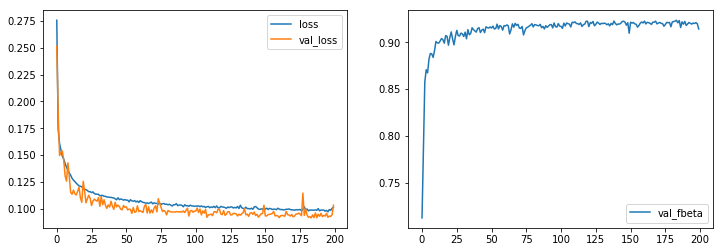

In [22]:
print("Max score %f at epoch %d" % (np.max(scores), np.argmax(scores)))
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_callback.history['loss'])
plt.plot(history_callback.history['val_loss'])
plt.legend(labels=['loss', 'val_loss'])
plt.subplot(1, 2, 2)
plt.plot(scores)
plt.legend(labels=['val_fbeta'])
plt.show()